<a href="https://colab.research.google.com/github/Holzlsauer/handson-machine-learning/blob/main/PART%20I%2C%20The%20Fundamentals%20of%20Machine%20Learning/Chapter_III/mnist_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.ndimage.interpolation import shift
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

# Setup

In [ ]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [ ]:
X, y = mnist['data'], mnist['target'].astype('uint8')

print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

X shape: (70000, 784)
y shape: (70000,)


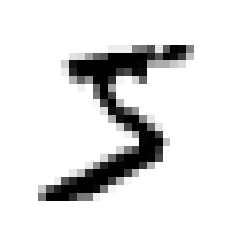


Legenda: 5


In [ ]:
def plot_digit(digit):
    plt.imshow(digit.reshape(28,28), cmap='gray_r')
    plt.axis('off')
    plt.show()

plot_digit(X[0])
print(f'\nLegenda: {y[0]}')

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Digit 5 Classifier

In [ ]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [ ]:
sgd = SGDClassifier(random_state=42)
sgd.fit(X_train, y_train_5)

In [ ]:
sgd.predict([X[0]])

## Metrics

In [ ]:
cross_val_score(sgd, X_train, y_train_5, cv=5, scoring='accuracy')

In [ ]:
y_train_pred_5 = cross_val_predict(sgd, X_train, y_train_5, cv=5)

In [ ]:
confusion_matrix(y_train_5, y_train_pred_5)

### Precision / Recall / F1-Score

In [ ]:
def report(y_true, y_pred):
    print(f'{"Precision score: ":<18}{precision_score(y_pred, y_true)}')
    print(f'{"Recall score: ":<18}{recall_score(y_pred, y_true)}')
    print(f'{"F1 score: ":<18}{f1_score(y_pred, y_true)}')

In [ ]:
report(y_train_5, y_train_pred_5)

In [ ]:
y_scores = cross_val_predict(sgd, X_train, y_train_5, cv=5, method='decision_function')

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

plt.figure(figsize=(12,6))
plt.plot(thresholds, precisions[:-1], '--b', linewidth=3, label='Precision')
plt.plot(thresholds, recalls[:-1], '--r', linewidth=3, label='Recall')
plt.legend()
plt.xlabel("Threshold", fontsize=16)
plt.grid(True)
# plt.axis([-50000, 50000, 0, 1])
plt.show()

In [ ]:
# Gettin the threshold that gives 90% of precision
index = np.argmax(precisions >= .9) # Returns the position of the first True element
threshold_90 = thresholds[index]
threshold_90

In [ ]:
y_pred_90 = (y_scores >= threshold_90)
report(y_pred_90, y_train_5)

### Roc Curve

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, 'b', linewidth=2, label='ROC Curve')
plt.plot([0, 1], [0, 1], '--k', linewidth=2)
plt.ylabel('True Positive Rate (Recall)', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=16)
plt.legend()
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.show()

In [ ]:
sgd_roc_auc = roc_auc_score(y_train_5, y_scores)
sgd_roc_auc

## Comparing models

In [ ]:
rfc = RandomForestClassifier(random_state=42)
rfc_scores = cross_val_predict(rfc, X_train, y_train_5, cv=5, method='predict_proba')

y_scores_forest = rfc_scores[:,1] # Prob. of True
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest) 

In [ ]:
rfc_roc_auc = roc_auc_score(y_train_5, y_scores_forest)
rfc_roc_auc

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, 'b', linewidth=2, label=f'Stochastic Gradient Descent: {str(sgd_roc_auc)[:5]}')
plt.plot(fpr_forest, tpr_forest, 'r', linewidth=2, label=f'Random Forest: {str(rfc_roc_auc)[:5]}')
plt.plot([0, 1], [0, 1], '--k', linewidth=2)
plt.ylabel('True Positive Rate (Recall)', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=16)
plt.legend()
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.show()

# Multiclass Classification

In [ ]:
sgd = SGDClassifier(random_state=42)
sgd.fit(X_train, y_train)
sgd.predict([X[0]])

In [ ]:
X0_scores = sgd.decision_function([X[0]])
X0_scores

In [ ]:
index = np.argmax(X0_scores)
index

In [ ]:
sgd.classes_

## Training a SGDClassifier as OvO

In [ ]:
sgd_ovo = OneVsOneClassifier(SGDClassifier(random_state=42))
sgd_ovo.fit(X_train, y_train)
sgd_ovo.predict([X[0]])

In [ ]:
len(sgd_ovo.estimators_)

## Evaluating

In [ ]:
cross_val_score(sgd, X_train, y_train, cv=5, scoring='accuracy')

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd, X_train_scaled, y_train, cv=5, scoring='accuracy')

### Confusion matrix

In [ ]:
y_scaled_rfc_scores = cross_val_predict(rfc, X_train_scaled, y_train, cv=5)

In [ ]:
confusion = confusion_matrix(y_train, y_scaled_rfc_scores)
confusion

In [ ]:
plt.figure(figsize=(12,12))
plt.matshow(confusion, cmap='gray')
plt.show()

In [ ]:
row_sums = confusion.sum(axis=1, keepdims=True)
norm_confusion = confusion / row_sums

np.fill_diagonal(norm_confusion, 0)

plt.figure(figsize=(8,8))
plt.matshow(norm_confusion, cmap=plt.cm.gray)
plt.show()

# Multilabel Classification

In [ ]:
# Create two labels
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 ==1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_multilabel)

In [ ]:
knn.predict([X[0]])

In [ ]:
y_multilabel[0]

In [ ]:
y_multilabel_knn_scores = cross_val_predict(knn, X_train, y_multilabel, cv=5)
f1_score(y_multilabel, y_multilabel_knn_scores, average='macro')

In [ ]:
# Giving weiths to labels based on their support
f1_score(y_multilabel, y_multilabel_knn_scores, average='weighted')

# Multioutput Classification

In [ ]:
# Creating noise to add to the digits
noise = np.random.randint(0, 100, X_train.shape)
X_train_noisy = X_train + noise
y_train_noisy = X_train # The 'label' is the clean image

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(X_train[7].reshape(28, 28), cmap='gray_r')
ax[1].imshow(X_train_noisy[7].reshape(28, 28), cmap='gray_r')

plt.suptitle('Clean digit vs Noisy digit', fontsize=16)
plt.show()

In [ ]:
knn.fit(X_train_noisy, y_train_noisy)
some_prediction = knn.predict([X_train_noisy[7]])

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(X_train_noisy[7].reshape(28, 28), cmap='gray_r')
ax[1].imshow(some_prediction.reshape(28, 28), cmap='gray_r')
ax[2].imshow(X_train[7].reshape(28, 28), cmap='gray_r')

plt.suptitle('Noisy - Predicted - Clean Digit', fontsize=16)
plt.show()

# Ex. 01

In [ ]:
knn  = KNeighborsClassifier()
cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy') # 'Base Model'

In [ ]:
param_grid = {
    'weights': ['uniform', 'distance'],
    'n_neighbors': [k for k in range(2, 7)]
}

In [ ]:
grid_search = GridSearchCV(knn, param_grid=param_grid, cv=5, scoring='accuracy', 
                           n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:689: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  p.join()


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [2, 3, 4, 5, 6],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=2)

In [ ]:
grid_search.best_params_

In [ ]:
best_knn = grid_search.best_estimator_
best_knn

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [ ]:
y_pred = best_knn.predict(X_test)
accuracy_score(y_test, y_pred)

# Ex. 02

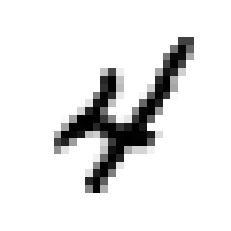

In [ ]:
plot_digit(X[9])

In [ ]:
def shift_digit(digit, x_axis, y_axis):
    digit = digit.reshape(28, 28)
    dir = [y_axis, x_axis]
    return shift(digit, dir, cval=0, mode='constant').reshape([-1])

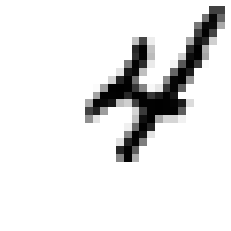

In [ ]:
plot_digit(shift_digit(X[9], 4, -4))

In [ ]:
# X_train_augmented = [image for image in X_train]
# y_train_augmented = [label for label in y_train]

# for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
#     for image, label in zip(X_train, y_train):
#         X_train_augmented.append(shift_digit(image, dx, dy))
#         y_train_augmented.append(label)

# X_train_augmented = np.array(X_train_augmented, dtype=object)
# y_train_augmented = np.array(y_train_augmented, dtype=object)

In [ ]:
# del X, y, X_train, y_train, mnist, dx, dy, image, label, knn

In [ ]:
# y_train_augmented_pred = best_knn.predict(X_test)
# accuracy_score(y_test, y_train_augmented_pred)